In [1]:
from sympy import *
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.integrate import odeint


In [2]:
time, w, m, c_0 = symbols("t w m c_0")
c = symbols("c", cls=Function)

dcdt = Eq(c(time).diff(time), w - c(time) * m)
c_eq = dsolve(dcdt, c(time), ics={c(0): c_0})
c_eq = simplify(c_eq)

display(dcdt, c_eq)


Eq(Derivative(c(t), t), -m*c(t) + w)

Eq(c(t), (c_0*m + w*exp(m*t) - w)*exp(-m*t)/m)

### Solução analítica

In [3]:
# solução analítica OD/DBO

OD_0 = 5.8
L_0 = 1.5

OD_old = 5.8
L_old = 1.5

# Constantes da equação

V = 25.6 * (10**6)  # m3
H = 5.6  # m
Os = 9.0  # mg/L
v_s = 1  # m/d
L_F4 = 1.5  # mg/L
L_TD4 = 1.7  # mg/L
L_TE10 = 1.3  # mg/L
OD_F4 = 8  # mg/L
OD_TD4 = 8  # mg/L
OD_TE10 = 8  # mg/L
kd = 1.5  # d-1
ka = 0.3  # d-1
k_sed = v_s / H
k_ra = 0.05  # d-1
k_n = 0.1  # d-1
k_g = 0.15  # d-1
r_ca = 50  # gC/mgChla
r_oc = 2.67  # gO/gC
r_on = 4.2  # gO/gN
L_n = 0.157  # mg/L
alpha = 0.0128  # mg/L
L_part = 0.5  # adimensional
SOD = 1  # gO2/m2
pa = r_oc * r_ca * k_g * alpha  # mgOD/L

# Balanço hidrico

Q_F4 = 2.0 * 86400  # * 1000 #m3/d
Q_TD4 = 0.3 * 86400  # * 1000#m3/d
Q_TE10 = 0.15 * 86400  # * 1000#m3/d

bal_hid = Q_F4 + Q_TD4 + Q_TE10

# Cargas externas

carga_L = L_F4 * Q_F4 + L_TD4 * Q_TD4 + L_TE10 * Q_TE10
carga_OD = OD_F4 * Q_F4 + OD_TD4 * Q_TD4 + OD_TE10 * Q_TE10

# Passo no tempo

t = 0
dt = 1
tmax = 291
tempo = np.arange(0, tmax, dt)

# Equação OD - dDOdt = -kd*L + ka*(Os-OD) - r_on*k_n*L_n - r_ca*r_oc*k_ra*alpha - (SOD/H) + pa  - (OD/V)*bal_hid + carga_OD/V
m_OD = ka + bal_hid / V
w_OD = (
    -kd * L_old
    + ka * Os
    - r_on * k_n * L_n
    - r_ca * r_oc * k_ra * alpha
    - (SOD / H)
    + pa
    + carga_OD / V
)

# Equação DBO - dLdt = - kd*L + r_ca*r_oc*k_ra*alpha - k_sed*(1-L_part)*L - (L/V)*bal_hid + carga_L/V
m_L = kd + bal_hid / V + k_sed * (1 - L_part)
w_L = r_ca * r_oc * k_ra * alpha + carga_L / V

# Lista vazia com os resultados calculados

OD_lista = []
L_lista = []


while t < tmax:

    OD_new = ((OD_0 * m_OD + w_OD * np.exp(m_OD * t) - w_OD) * np.exp(-m_OD * t)) / m_OD
    L_new = ((L_0 * m_L + w_L * np.exp(m_L * t) - w_L) * np.exp(-m_L * t)) / m_L

    t = t + dt

    OD_old = OD_new
    L_old = L_new

    w_OD = (
        -kd * L_old
        + ka * Os
        - r_on * k_n * L_n
        - r_ca * r_oc * k_ra * alpha
        - (SOD / H)
        + pa
        + carga_OD / V
    )

    OD_lista.append(OD_new)
    L_lista.append(L_new)


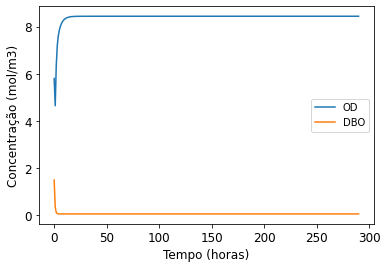

In [4]:
fig, ax = plt.subplots() 
ax.tick_params(axis='both', labelsize=12) #increase font size for ticks
plt.ylabel(r'Concentração (mol/m3)', fontsize=12) #y label
plt.xlabel(r'Tempo (horas)', fontsize=12) #y label
ax.plot(tempo, OD_lista, label='OD') 
ax.plot(tempo, L_lista, label='DBO') 
ax.legend()
#plt.savefig('concentracoes.png', dpi = 300)
plt.show()

### Solução numérica

In [5]:
# solução numérica OD/DBO


def funcao_reacao_parcial(z, t):

    L, OD = z  # Definir as variaveis

    # Constantes da reação

    V = 25.6 * (10**6)  # m3
    H = 5.6  # m
    Os = 9.0  # mg/L
    v_s = 1  # m/d
    L_F4 = 1.5  # mg/L
    L_TD4 = 1.7  # mg/L
    L_TE10 = 1.3  # mg/L
    OD_F4 = 8  # mg/L
    OD_TD4 = 8  # mg/L
    OD_TE10 = 8  # mg/L
    kd = 1.5  # d-1
    ka = 0.3  # d-1
    k_sed = v_s / H
    k_ra = 0.05  # d-1
    k_n = 0.1  # d-1
    k_g = 0.15  # d-1
    r_ca = 50  # gC/mgChla
    r_oc = 2.67  # gO/gC
    r_on = 4.2  # gO/gN
    L_n = 0.157  # mg/L
    alpha = 0.0128  # mg/L
    L_part = 0.5  # adimensional
    SOD = 1  # gO2/m2
    pa = r_oc * r_ca * k_g * alpha  # mgOD/L

    # Balanço hidrico

    Q_F4 = 2.0 * 86400  # * 1000 #m3/d
    Q_TD4 = 0.3 * 86400  # * 1000#m3/d
    Q_TE10 = 0.15 * 86400  # * 1000#m3/d

    bal_hid = Q_F4 + Q_TD4 + Q_TE10

    # Cargas externas

    carga_L = L_F4 * Q_F4 + L_TD4 * Q_TD4 + L_TE10 * Q_TE10
    carga_OD = OD_F4 * Q_F4 + OD_TD4 * Q_TD4 + OD_TE10 * Q_TE10

    # Definir as funções

    dLdt = (
        -kd * L
        + r_ca * r_oc * k_ra * alpha
        - k_sed * (1 - L_part) * L
        - (L / V) * bal_hid
        + carga_L / V
    )

    dODdt = (
        -kd * L
        + ka * (Os - OD)
        - r_on * k_n * L_n
        - r_ca * r_oc * k_ra * alpha
        - (SOD / H)
        + pa
        - (OD / V) * bal_hid
        + carga_OD / V
    )

    return dLdt, dODdt


# Condições iniciais

L0_1 = 1.5  # mg/L
OD0_1 = 5.8  # mg/L
z0_1 = L0_1, OD0_1

# Passo no tempo
t1 = np.linspace(0, 291, 291)


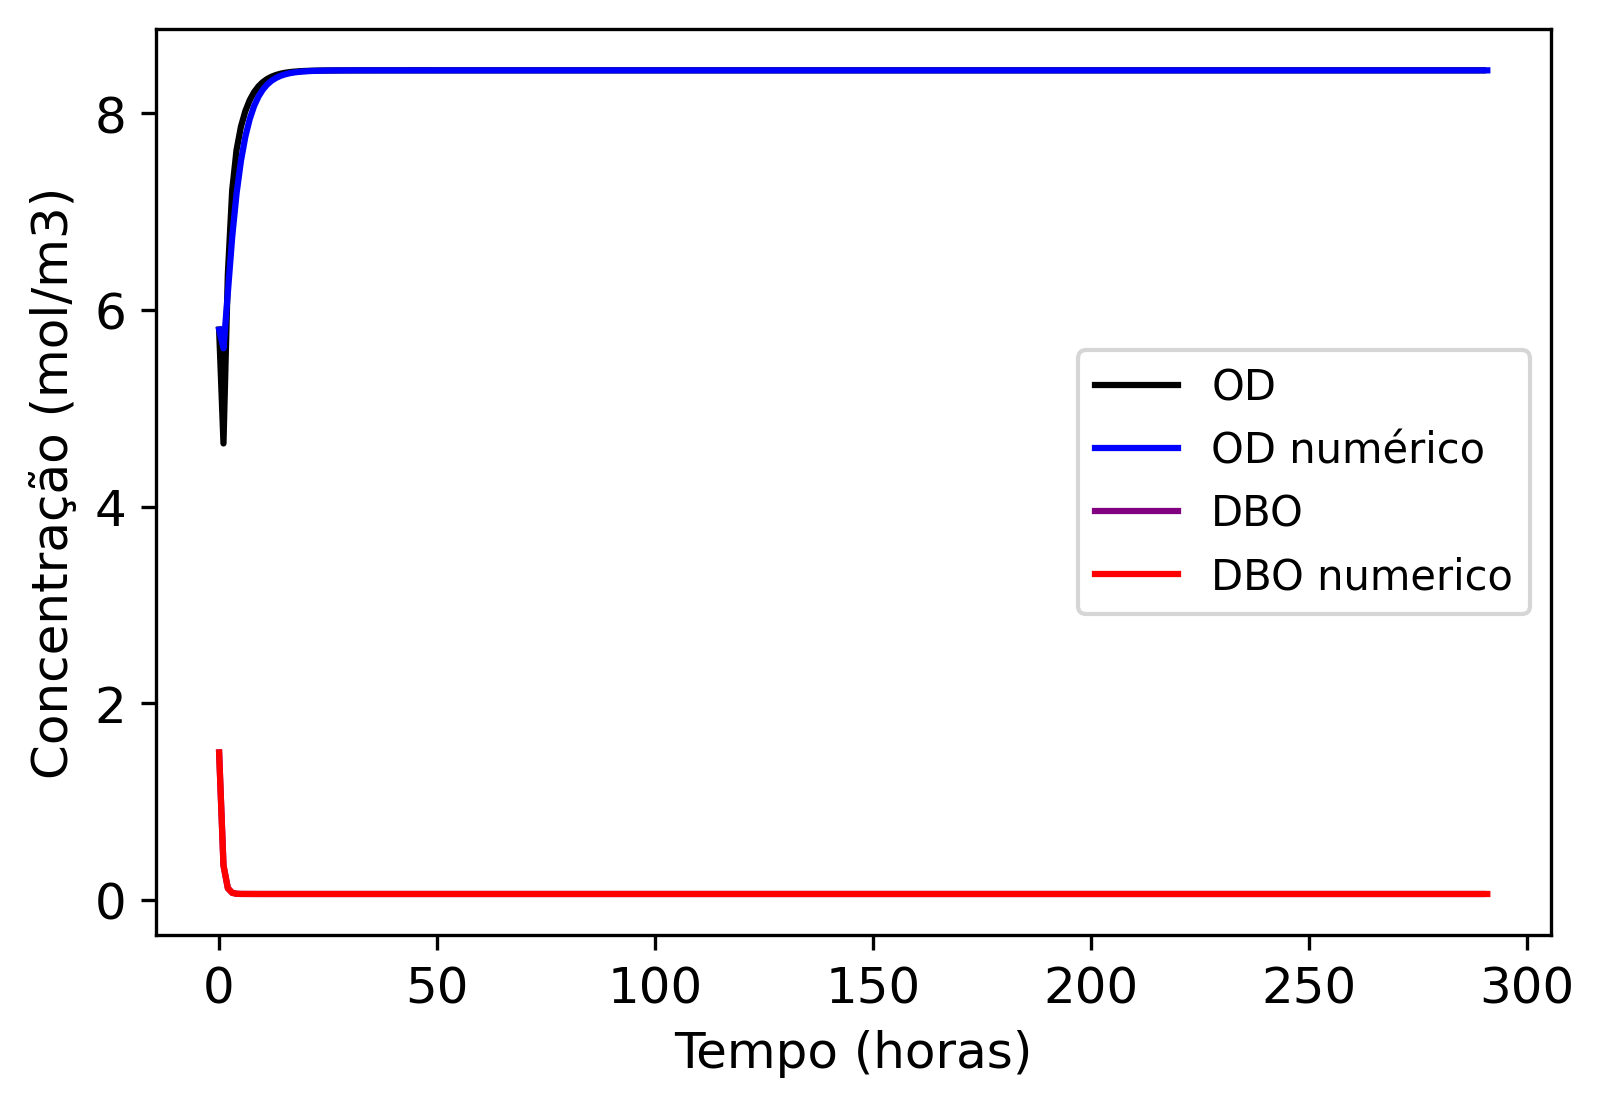

In [6]:
# Integrar as equações com odeint

funcao_teste = odeint(funcao_reacao_parcial, z0_1, t1)
L1, OD1 = funcao_teste.T

# plt.plot(t1, L1, 'r', label = 'DBO')
# plt.plot(t1, OD1, 'b', label = 'OD numérico')
# plt.plot(tempo, OD_lista, 'purble', label = "OD analitico" )
# plt.plot(tempo, L_lista,'black', label='DBO analitico')

fig1, ax1 = plt.subplots(dpi = 300)
ax1.tick_params(axis="both", labelsize=12)  # increase font size for ticks
plt.ylabel(r"Concentração (mol/m3)", fontsize=12)  # y label
plt.xlabel(r"Tempo (horas)", fontsize=12)  # y label
ax1.plot(tempo, OD_lista, "black", label="OD")
ax1.plot(t1, OD1, "b", label="OD numérico")
ax1.plot(tempo, L_lista, "purple", label="DBO")
ax1.plot(t1, L1, "r", label="DBO numerico")
ax1.legend()
# plt.savefig('concentracoes.png', dpi = 300)
plt.show()


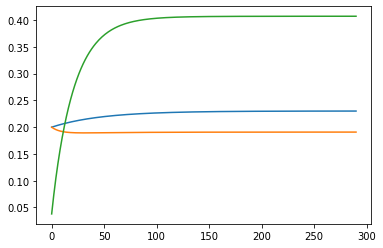

In [7]:
# solução analítica OD/DBO + nitrogenio

OD_0 = 5.8
L_0 = 1.5
No_0 = 0.2
Na_0 = 0.2
Nn_0 = 0.038

OD_old = 5.8
L_old = 1.5
No_old = 0.2 
Na_old = 0.2
Nn_old = 0.038

# Constantes da equação

V = 25.6 * (10**6)  # m3
H = 5.6  # m
Os = 9.0  # mg/L
v_s = 1  # m/d

L_F4 = 1.5  # mg/L
L_TD4 = 1.7  # mg/L
L_TE10 = 1.3  # mg/L
OD_F4 = 8  # mg/L
OD_TD4 = 8  # mg/L
OD_TE10 = 8  # mg/L
No_F4= 0.1 #mg/L
No_TD4 = 0.2 #mg/L
No_TE10 = 0.15 #mg/L
Na_F4 = 0.3 #mg/L
Na_TD4 = 0.35 #mg/L
Na_TE10 = 0.35 #mg/L
Nn_F4 = 0.3 #mg/L
Nn_TD4 = 0.3 #mg/L
Nn_TE10 = 0.3 #mg/L

kd = 1.5  # d-1
ka = 0.3  # d-1
k_sed = v_s / H
k_ra = 0.05  # d-1
k_n = 0.1  # d-1
k_g = 0.15  # d-1
kn = 0.09
k_ea = 0.17
k_dn = 0.04
k_oa = 0.013

r_ca = 50  # gC/mgChla
r_oc = 2.67  # gO/gC
r_on = 4.2  # gO/gN
r_na = 7 #gN/gChla [7 a 15]

f_nod = 1
f_on = 0.2 #adimensional
L_n = 0.157  # mg/L
alpha = 0.0128  # mg/L
L_part = 0.5  # adimensional
SOD = 1  # gO2/m2
pa = r_oc * r_ca * k_g * alpha  # mgOD/L

# Balanço hidrico

Q_F4 = 2.0 * 86400  # * 1000 #m3/d
Q_TD4 = 0.3 * 86400  # * 1000#m3/d
Q_TE10 = 0.15 * 86400  # * 1000#m3/d

bal_hid = Q_F4 + Q_TD4 + Q_TE10

# Cargas externas

carga_L = L_F4 * Q_F4 + L_TD4 * Q_TD4 + L_TE10 * Q_TE10
carga_OD = OD_F4 * Q_F4 + OD_TD4 * Q_TD4 + OD_TE10 * Q_TE10
carga_No = No_F4*Q_F4 + No_TD4*Q_TD4 + No_TE10*Q_TE10
carga_Na = Na_F4*Q_F4 + Na_TD4*Q_TD4 + Na_TE10*Q_TE10
carga_Nn = Nn_F4*Q_F4 + Nn_TD4*Q_TD4 + Nn_TE10*Q_TE10

# Passo no tempo

t = 0
dt = 1
tmax = 291
tempo = np.arange(0, tmax, dt)

# Equação OD - dDOdt = -kd*L + ka*(Os-OD) - r_on*k_n*L_n - r_ca*r_oc*k_ra*alpha - (SOD/H) + pa  - (OD/V)*bal_hid + carga_OD/V
m_OD = ka + bal_hid / V
w_OD = (-kd * L_old + ka * Os - r_on * k_n * L_n - r_ca * r_oc * k_ra * alpha - (SOD / H) + pa + carga_OD / V)

# Equação DBO - dLdt = - kd*L + r_ca*r_oc*k_ra*alpha - k_sed*(1-L_part)*L - (L/V)*bal_hid + carga_L/V
m_L = kd + bal_hid / V + k_sed * (1 - L_part)
w_L = r_ca * r_oc * k_ra * alpha + carga_L / V

# Equação No - dNodt = -k_oa_var*No - k_sed*(1-f_nod)*No + r_na*k_ra_var*f_on*alpha + r_na*k_ea*f_on*alpha + carga_No_var/V - (No/V)*bal_hid_var
m_No = k_oa + k_sed*(1-f_nod) + bal_hid/V
w_No = r_na*k_ra*f_on*alpha + r_na*k_ea*f_on*alpha + carga_No/V 

# Equação Na - dNadt = k_oa_var*No - kn_var*Na + r_na*k_ra_var*(1-f_on)*alpha + r_na*k_ea*(1-f_on)*alpha + carga_Na_var/V - (Na/V)*bal_hid_var - Na*r_na*k_g*alpha # (da amonia negativa)
m_Na = kn + bal_hid/V + r_na*k_g*alpha
w_Na = k_oa*No_old + r_na*k_ra*(1-f_on)*alpha + r_na*k_ea*(1-f_on)*alpha + carga_Na/V

# Equação Nn - dNndt = kn_var*Na - k_dn_var*Nn + carga_Nn_var/V - (Nn/V)*bal_hid_var #-(1-Na)*r_na*k_g*alpha
m_Nn = k_dn + bal_hid/V
w_Nn = kn*Na_old + carga_Nn/V
    
# Lista vazia com os resultados calculados

OD_lista = []
L_lista = []
No_lista = []
Na_lista = []
Nn_lista = []

while t < tmax:

    OD_new = ((OD_0 * m_OD + w_OD * np.exp(m_OD * t) - w_OD) * np.exp(-m_OD * t)) / m_OD
    
    L_new = ((L_0 * m_L + w_L * np.exp(m_L * t) - w_L) * np.exp(-m_L * t)) / m_L

    No_new = ((No_0 * m_No + w_No * np.exp(m_No * t) - w_No) * np.exp(-m_No * t)) / m_No

    Na_new = ((Na_0 * m_Na + w_Na * np.exp(m_Na * t) - w_Na) * np.exp(-m_Na * t)) / m_Na

    Nn_new = ((Nn_0 * m_Nn + w_Nn * np.exp(m_Nn * t) - w_Nn) * np.exp(-m_Nn * t)) / m_Nn

    t = t + dt

    OD_old = OD_new
    L_old = L_new
    No_old = No_new
    Na_old = Na_new
    Nn_old = Nn_new

    w_OD = (-kd * L_old + ka * Os - r_on * k_n * L_n - r_ca * r_oc * k_ra * alpha - (SOD / H) + pa + carga_OD / V)

    w_Na = k_oa*No_old + r_na*k_ra*(1-f_on)*alpha + r_na*k_ea*(1-f_on)*alpha + carga_Na/V

    w_Nn = kn*Na_old + carga_Nn/V    

    OD_lista.append(OD_new)
    L_lista.append(L_new)
    No_lista.append(No_new)
    Na_lista.append(Na_new)
    Nn_lista.append(Nn_new)

plt.plot(tempo, No_lista, label = 'No')
plt.plot(tempo, Na_lista, label = 'Na')
plt.plot(tempo, Nn_lista, label = 'Nn')

In [8]:
# Solução numérica OD/DBO + nitrogenio

def funcao_nitro_num (z, t):

    OD = z[0]
    L = z[1]
    No = z[2]
    Na = z[3]
    Nn = z[4]

    # Constantes da equação

    V = 25.6 * (10**6)  # m3
    H = 5.6  # m
    Os = 9.0  # mg/L
    v_s = 1  # m/d

    L_F4 = 1.5  # mg/L
    L_TD4 = 1.7  # mg/L
    L_TE10 = 1.3  # mg/L
    OD_F4 = 8  # mg/L
    OD_TD4 = 8  # mg/L
    OD_TE10 = 8  # mg/L
    No_F4= 0.1 #mg/L
    No_TD4 = 0.2 #mg/L
    No_TE10 = 0.15 #mg/L
    Na_F4 = 0.3 #mg/L
    Na_TD4 = 0.35 #mg/L
    Na_TE10 = 0.35 #mg/L
    Nn_F4 = 0.3 #mg/L
    Nn_TD4 = 0.3 #mg/L
    Nn_TE10 = 0.3 #mg/L

    kd = 1.5  # d-1
    ka = 0.3  # d-1
    k_sed = v_s / H
    k_ra = 0.05  # d-1
    k_n = 0.1  # d-1
    k_g = 0.15  # d-1
    kn = 0.09
    k_ea = 0.17
    k_dn = 0.04
    k_oa = 0.013

    r_ca = 50  # gC/mgChla
    r_oc = 2.67  # gO/gC
    r_on = 4.2  # gO/gN
    r_na = 7 #gN/gChla [7 a 15]

    f_nod = 1
    f_on = 0.2 #adimensional
    L_n = 0.157  # mg/L
    alpha = 0.0128  # mg/L
    L_part = 0.5  # adimensional
    SOD = 1  # gO2/m2
    pa = r_oc * r_ca * k_g * alpha  # mgOD/L

    # Balanço hidrico

    Q_F4 = 2.0 * 86400  # * 1000 #m3/d
    Q_TD4 = 0.3 * 86400  # * 1000#m3/d
    Q_TE10 = 0.15 * 86400  # * 1000#m3/d

    bal_hid = Q_F4 + Q_TD4 + Q_TE10

    # Cargas externas

    carga_L = L_F4 * Q_F4 + L_TD4 * Q_TD4 + L_TE10 * Q_TE10
    carga_OD = OD_F4 * Q_F4 + OD_TD4 * Q_TD4 + OD_TE10 * Q_TE10
    carga_No = No_F4*Q_F4 + No_TD4*Q_TD4 + No_TE10*Q_TE10
    carga_Na = Na_F4*Q_F4 + Na_TD4*Q_TD4 + Na_TE10*Q_TE10
    carga_Nn = Nn_F4*Q_F4 + Nn_TD4*Q_TD4 + Nn_TE10*Q_TE10

    dODdt = -kd*L + ka*(Os-OD) - r_on*k_n*L_n - r_ca*r_oc*k_ra*alpha - (SOD/H) + pa  - (OD/V)*bal_hid + carga_OD/V

    dLdt = - kd*L + r_ca*r_oc*k_ra*alpha - k_sed*(1-L_part)*L - (L/V)*bal_hid + carga_L/V

    dNodt = -k_oa*No - k_sed*(1-f_nod)*No + r_na*k_ra*f_on*alpha + r_na*k_ea*f_on*alpha + carga_No/V - (No/V)*bal_hid
    
    dNadt = k_oa*No - kn*Na + r_na*k_ra*(1-f_on)*alpha + r_na*k_ea*(1-f_on)*alpha + carga_Na/V - (Na/V)*bal_hid - Na*r_na*k_g*alpha # (da amonia negativa)
    
    dNndt = kn*Na - k_dn*Nn + carga_Nn/V - (Nn/V)*bal_hid #-(1-Na)*r_na*k_g*alpha

    return dODdt, dLdt, dNodt, dNadt, dNndt

# Condições iniciais

z0 = [5.8, 1.5, 0.2, 0.2, 0.038]

# Passo no tempo

tempo = np.arange(0, tmax, dt)

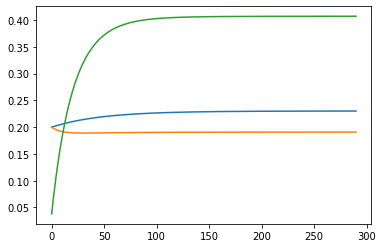

In [9]:
funcao_nitro = odeint(funcao_nitro_num, z0, tempo)
OD_nitro, L_nitro, No_nitro, Na_nitro, Nn_nitro = funcao_nitro.T

# plt.plot(tempo, OD_nitro, label = 'OD')
# plt.plot(tempo, L_nitro, label = 'L')
plt.plot(tempo, No_nitro, label = 'No')
plt.plot(tempo, Na_nitro, label = 'Na')
plt.plot(tempo, Nn_nitro, label = 'Nn')

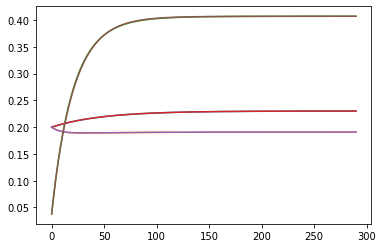

In [10]:
plt.plot(tempo, No_nitro, label = 'No')
plt.plot(tempo, Na_nitro, label = 'Na')
plt.plot(tempo, Nn_nitro, label = 'Nn')
plt.plot(tempo, No_lista, label = 'No')
plt.plot(tempo, Na_lista, label = 'Na')
plt.plot(tempo, Nn_lista, label = 'Nn')

In [11]:
# Solução analítica fósforo

P_org_0 = 0.021
P_inorg_0 = 0.0039

P_org_old = 0.021
P_inorg_old = 0.0039

# Constantes da equação

V = 25.6 * (10**6)  # m3
H = 5.6  # m
Os = 9.0  # mg/L
v_s = 1  # m/d

k_sed = v_s / H
k_mineral = 0.1
k_ra = 0.05
k_ea = 0.17

r_pa = 0.5 # gP/gChla [0.5 a 1]
f_op = 0.1 #adimensional [0.1 a 0.9]
alpha = 0.0128

P_org_F4 = 0.02 #mg/L
P_org_TD4 = 0.015 #mg/L
P_org_TE10 = 0.02 #mg/L
P_in_F4 = 0.01 #mg/L
P_in_TD4 = 0.015 #mg/L
P_in_TE10 = 0.01 #mg/L

# Balanço hidrico

Q_F4 = 2.0 * 86400  # * 1000 #m3/d
Q_TD4 = 0.3 * 86400  # * 1000#m3/d
Q_TE10 = 0.15 * 86400  # * 1000#m3/d

bal_hid = Q_F4 + Q_TD4 + Q_TE10

# Cargas externas

carga_P_org = P_org_F4*Q_F4 + P_org_TD4*Q_TD4 + P_org_TE10*Q_TE10
carga_P_in = P_in_F4*Q_F4 + P_in_TD4*Q_TD4 + P_in_TE10*Q_TE10

# Passo no tempo

t = 0
dt = 1
tmax = 291
tempo = np.arange(0, tmax, dt)

# Equação P_org - dP_orgdt = -k_mineral_var*P_org + r_pa*k_ra_var*f_op*alpha + r_pa*k_ea*f_op*alpha + carga_P_org_var/V - (P_org/V)*bal_hid_var
m_P_org = k_mineral + bal_hid/V
w_P_org = r_pa*k_ra*f_op*alpha + r_pa*k_ea*f_op*alpha + carga_P_org/V

# Equação P_inorg - dP_indt = k_mineral_var*P_org - k_sed*P_in +r_pa*k_ra_var*(1-f_op)*alpha + r_pa*k_ea*(1-f_op)*alpha + carga_P_in_var/V - (P_in/V)*bal_hid_var
m_P_inorg = k_sed + bal_hid/V
w_P_inorg = k_mineral*P_org_old +r_pa*k_ra*(1-f_op)*alpha + r_pa*k_ea*(1-f_op)*alpha + carga_P_in/V

#Lista vazia com os resultados

P_org_lista = []
P_inorg_lista = []

while t < tmax:

    P_org_new = ((P_org_0 * m_P_org + w_P_org * np.exp(m_P_org * t) - w_P_org) * np.exp(-m_P_org * t)) / m_P_org

    P_inorg_new = ((P_inorg_0 * m_P_inorg + w_P_inorg * np.exp(m_P_inorg * t) - w_P_inorg) * np.exp(-m_P_inorg * t)) / m_P_inorg

    t = t + dt

    P_org_old = P_org_new
    P_inorg_old = P_inorg_new

    w_P_inorg = k_mineral*P_org_old +r_pa*k_ra*(1-f_op)*alpha + r_pa*k_ea*(1-f_op)*alpha + carga_P_in/V

    P_org_lista.append(P_org_new)
    P_inorg_lista.append(P_inorg_new)

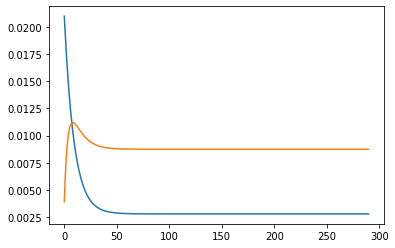

In [12]:
plt.plot(tempo, P_org_lista)
plt.plot(tempo, P_inorg_lista)

In [13]:
# Solução numérica fósforo

def reacao_fosforo (z, t):
    
    P_org = z[0]
    P_inorg = z[1]
    # Constantes da equação

    V = 25.6 * (10**6)  # m3
    H = 5.6  # m
    Os = 9.0  # mg/L
    v_s = 1  # m/d

    k_sed = v_s / H
    k_mineral = 0.1
    k_ra = 0.05
    k_ea = 0.17

    r_pa = 0.5 # gP/gChla [0.5 a 1]
    f_op = 0.1 #adimensional [0.1 a 0.9]
    alpha = 0.0128

    P_org_F4 = 0.02 #mg/L
    P_org_TD4 = 0.015 #mg/L
    P_org_TE10 = 0.02 #mg/L
    P_in_F4 = 0.01 #mg/L
    P_in_TD4 = 0.015 #mg/L
    P_in_TE10 = 0.01 #mg/L

    # Balanço hidrico

    Q_F4 = 2.0 * 86400  # * 1000 #m3/d
    Q_TD4 = 0.3 * 86400  # * 1000#m3/d
    Q_TE10 = 0.15 * 86400  # * 1000#m3/d

    bal_hid = Q_F4 + Q_TD4 + Q_TE10

    # Cargas externas

    carga_P_org = P_org_F4*Q_F4 + P_org_TD4*Q_TD4 + P_org_TE10*Q_TE10
    carga_P_inorg = P_in_F4*Q_F4 + P_in_TD4*Q_TD4 + P_in_TE10*Q_TE10

    dP_orgdt = -k_mineral*P_org + r_pa*k_ra*f_op*alpha + r_pa*k_ea*f_op*alpha + carga_P_org/V - (P_org/V)*bal_hid

    dP_inorgdt = k_mineral*P_org - k_sed*P_inorg +r_pa*k_ra*(1-f_op)*alpha + r_pa*k_ea*(1-f_op)*alpha + carga_P_inorg/V - (P_inorg/V)*bal_hid

    return dP_orgdt, dP_inorgdt

tempo = np.arange(0, tmax, dt)

z0_fosf = [0.021, 0.0039]
    

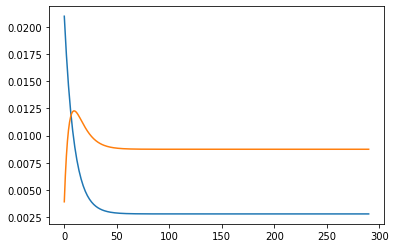

In [14]:
funcao_fosf = odeint(reacao_fosforo, z0_fosf, tempo)
P_org, P_inorg = funcao_fosf.T

plt.plot(tempo, P_org)
plt.plot(tempo, P_inorg)

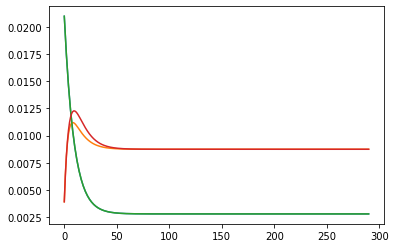

In [15]:
plt.plot(tempo, P_org_lista)
plt.plot(tempo, P_inorg_lista)
plt.plot(tempo, P_org)
plt.plot(tempo, P_inorg)

#### R², erro médio quadrado e erro relativo


In [19]:
# R2
from sklearn.metrics import r2_score

print(r2_score(OD_lista, OD1),
r2_score(L_lista, L1),
r2_score(No_lista, No_nitro),
r2_score(Na_lista, Na_nitro),
r2_score(Nn_lista, Nn_nitro),
r2_score(P_org_lista, P_org),
r2_score(P_inorg_lista, P_inorg))


0.9411341114565018 0.9999985948417348 0.9999999999999097 0.987479134087467 0.9998760625321332 0.9999999999995702 0.766857201132388


In [27]:
# Erro médio quadrado

#OD
OD_array = np.array(OD_lista)

diferenca_OD = OD_array - OD1
quadrado_diferenca_OD = diferenca_OD **2
soma_OD = quadrado_diferenca_OD.sum()
erro_medio_quadrado_OD = soma_OD/len(quadrado_diferenca_OD)
print(f'Erro medio quadrado OD: \n{erro_medio_quadrado_OD}')

#No
No_array = np.array(No_lista)

diferenca_No = No_array - No_nitro
quadrado_diferenca_No = diferenca_No **2
soma_No = quadrado_diferenca_No.sum()
erro_medio_quadrado_No = soma_No/len(quadrado_diferenca_No)
print(f'Erro medio quadrado No: \n{erro_medio_quadrado_No}')

#Na
Na_array = np.array(Na_lista)

diferenca_Na = Na_array - Na_nitro
quadrado_diferenca_Na = diferenca_Na **2
soma_Na = quadrado_diferenca_Na.sum()
erro_medio_quadrado_Na = soma_Na/len(quadrado_diferenca_Na)
print(f'Erro medio quadrado Na: \n{erro_medio_quadrado_Na}')

#Nn
Nn_array = np.array(Nn_lista)

diferenca_Nn = Nn_array - Nn_nitro
quadrado_diferenca_Nn = diferenca_Nn **2
soma_Nn = quadrado_diferenca_Nn.sum()
erro_medio_quadrado_Nn = soma_Nn/len(quadrado_diferenca_Nn)
print(f'Erro medio quadrado Nn: \n{erro_medio_quadrado_Nn}')

#P_org
P_org_array = np.array(P_org_lista)

diferenca_P_org = P_org_array - P_org
quadrado_diferenca_P_org = diferenca_P_org **2
soma_P_org = quadrado_diferenca_P_org.sum()
erro_medio_quadrado_P_org = soma_P_org/len(quadrado_diferenca_P_org)
print(f'Erro medio quadrado P_org: \n{erro_medio_quadrado_P_org}')


#P_inorg
P_inorg_array = np.array(P_inorg_lista)

diferenca_P_inorg = P_inorg_array - P_inorg
quadrado_diferenca_P_inorg = diferenca_P_inorg **2
soma_P_inorg = quadrado_diferenca_P_inorg.sum()
erro_medio_quadrado_P_inorg = soma_P_inorg/len(quadrado_diferenca_P_inorg)
print(f'Erro medio quadrado P_inorg: \n{erro_medio_quadrado_P_inorg}')



Erro medio quadrado OD: 
0.005651811426718707
Erro medio quadrado No: 
4.6009434916184695e-18
Erro medio quadrado Na: 
1.5825434937741163e-08
Erro medio quadrado Nn: 
5.388063710913941e-07
Erro medio quadrado P_org: 
2.3576932518849076e-18
Erro medio quadrado P_inorg: 
7.552397024785941e-08


In [ ]:
# Erro relativo  = (valor medido - valor modelado)/valor medido



